# Main Analysis Pipeline

In [1]:
get_ipython().magic(u'run visualizations.ipynb')
import sys
from hits import CyDetHits, CTHHits, CDCHits, FlatHits
from memory_profiler import memory_usage
from pprint import pprint
from collections import Counter
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib


## Convenience Functions

In [2]:
def get_measurment_and_neighbours(hit_sample, measurement, events=None):
    """
    Get the measurement on the wire and its neighbours in a classification-friendly way
    
    :return: a list of three numpy arrays of measurement 1) on wire, 2) to left, 3) to right
    """
    return [hit_sample.get_measurement(measurement, 
                                       events, 
                                       shift=i, 
                                       only_hits=True, 
                                       flatten=True) 
                for i in [0,-1,1]] 

## Import Signal Hits

In [3]:
from root_numpy import list_branches

In [4]:
file_base = "/vols/comet/users/elg112/ICEDUST"\
            "/local_storage/SimDetectorResponse_tree"\
            "/test_signal_sample/03000014_"
cdc_sig_file = file_base + "cdc_sum_sig.root"
cth_sig_file = file_base + "cth_mc_sig.root"

In [5]:
file_base = "/vols/comet/users/elg112/ICEDUST"\
            "/local_storage/SimDetectorResponse_tree"\
            "/test_signal_sample/100k_"
cdc_sig_file = file_base + "cdc_sum_hits.root"
cth_sig_file = file_base + "cth_mc_hits.root"

In [6]:
file_base = "/vols/comet/users/elg112/ICEDUST"\
            "/local_storage/Blessed_Outputs"\
            "/335e4_"
cdc_sig_file = file_base + "cdc_signal.root"
cth_sig_file = file_base + "cth_signal.root"

In [7]:
file_base = "/vols/comet/users/elg112/ICEDUST"\
            "/local_storage/Blessed_Outputs"\
            "/2e5_"
cdc_sig_file = file_base + "cdc_signal.root"
cth_sig_file = file_base + "cth_signal.root"

In [8]:
file_base = "/vols/comet/users/elg112/ICEDUST"\
            "/local_storage/Blessed_Outputs"\
            "/2e5_"
cdc_sig_file = file_base + "cdc_signal_xtcurve.root"
cth_sig_file = file_base + "cth_signal_xtcurve.root"

In [9]:
all_branches = set(list_branches(cdc_sig_file, treename="COMETEventsSummary"))
pprint(all_branches)

set(['CDCHit.fChannel',
     'CDCHit.fCharge',
     'CDCHit.fDetectedTime',
     'CDCHit.fDriftDist',
     'CDCHit.fDriftTime',
     'CDCHit.fEventNumber',
     'CDCHit.fHitNumber',
     'CDCHit.fMCMom.fX',
     'CDCHit.fMCMom.fY',
     'CDCHit.fMCMom.fZ',
     'CDCHit.fMCPos.fE',
     'CDCHit.fMCPos.fP.fX',
     'CDCHit.fMCPos.fP.fY',
     'CDCHit.fMCPos.fP.fZ',
     'CDCHit.fTrack.fPID',
     'CDCHit.fTrack.fParentTrackID',
     'CDCHit.fTrack.fStartMomentum.fX',
     'CDCHit.fTrack.fStartMomentum.fY',
     'CDCHit.fTrack.fStartMomentum.fZ',
     'CDCHit.fTrack.fStartPosGlobal.fE',
     'CDCHit.fTrack.fStartPosGlobal.fP.fX',
     'CDCHit.fTrack.fStartPosGlobal.fP.fY',
     'CDCHit.fTrack.fStartPosGlobal.fP.fZ',
     'CDCHit.fTrack.fStopMomentum.fX',
     'CDCHit.fTrack.fStopMomentum.fY',
     'CDCHit.fTrack.fStopMomentum.fZ',
     'CDCHit.fTrack.fStopPosGlobal.fE',
     'CDCHit.fTrack.fStopPosGlobal.fP.fX',
     'CDCHit.fTrack.fStopPosGlobal.fP.fY',
     'CDCHit.fTrack.fStopPosGlobal

TClass::TClass:0: RuntimeWarning: no dictionary for class COMET::ICOMETEvent is available
TClass::TClass:0: RuntimeWarning: no dictionary for class COMET::IDataVector is available
TClass::TClass:0: RuntimeWarning: no dictionary for class COMET::IData is available
TClass::TClass:0: RuntimeWarning: no dictionary for class COMET::IDatum is available
TClass::TClass:0: RuntimeWarning: no dictionary for class COMET::ICOMETContext is available
TClass::TClass:0: RuntimeWarning: no dictionary for class COMET::ISHAHashValue is available
TClass::TClass:0: RuntimeWarning: no dictionary for class COMET::IAlignmentId is available
TClass::TClass:0: RuntimeWarning: no dictionary for class COMET::ICOMETEvent::Header is available


In [10]:
# Define some branches to import
## Existing branches
prefix = "CDCHit.f"
drift_name = prefix + "DriftTime"
track_id_name = prefix + "Track.fTrackID"

## Branches not needed
drift_dist_name = prefix + "DriftDist"
turn_id_name = prefix + "TurnID"
pid_name = prefix + "Track.fPID"
parent_track_id_name = prefix + "Track.fParentTrackID"
all_momentum_names = [ prefix + "Track.f" + st_sp + "Momentum.f" + coor 
                       for st_sp in ["Start", "Stop"] for coor in ["X", "Y", "Z"] ]
all_pos_names = [ prefix + "Track.f" + st_sp + "PosGlobal.f" + coor 
                       for st_sp in ["Start", "Stop"] for coor in ["P.fX", "P.fY", "P.fZ", "E"] ]
hit_pos_names = [ prefix + "MCPos.f" + coor for coor in ["P.fX", "P.fY", "P.fZ", "E"] ]
hit_mom_names = [ prefix + "MCMom.f" + coor for coor in ["X", "Y", "Z"] ]


## Branches to be filled
row_name = "Layers"
cell_id_name = prefix + "CellID"
lcl_scr_name = prefix + "Local_Score"
ngh_scr_name = prefix + "Neigh_Score"
hgh_scr_name = prefix + "Hough_Score"
trk_scr_name = prefix + "Track_Score"
rel_time_name = prefix + "Relative_Time"
take_hit_name = prefix + "Take_Hit"
## Kinda both
sig_flag = "IsSig"

In [11]:
these_branches = [drift_name, 
                  track_id_name ]

## For track fitting
#these_branches += [turn_id_name, 
#                   drift_dist_name,
#                   pid_name,
#                   parent_track_id_name] +\
#                  hit_mom_names +\
#                  all_momentum_names +\
#                  all_pos_names +\
#                  hit_pos_names
                
empty_branches = [prefix + row_name, 
                  cell_id_name,
                  lcl_scr_name, 
                  ngh_scr_name, 
                  hgh_scr_name,
                  trk_scr_name, 
                  rel_time_name,
                  take_hit_name]

In [12]:
pprint(all_branches - set(these_branches))

set(['CDCHit.fChannel',
     'CDCHit.fCharge',
     'CDCHit.fDetectedTime',
     'CDCHit.fDriftDist',
     'CDCHit.fEventNumber',
     'CDCHit.fHitNumber',
     'CDCHit.fMCMom.fX',
     'CDCHit.fMCMom.fY',
     'CDCHit.fMCMom.fZ',
     'CDCHit.fMCPos.fE',
     'CDCHit.fMCPos.fP.fX',
     'CDCHit.fMCPos.fP.fY',
     'CDCHit.fMCPos.fP.fZ',
     'CDCHit.fTrack.fPID',
     'CDCHit.fTrack.fParentTrackID',
     'CDCHit.fTrack.fStartMomentum.fX',
     'CDCHit.fTrack.fStartMomentum.fY',
     'CDCHit.fTrack.fStartMomentum.fZ',
     'CDCHit.fTrack.fStartPosGlobal.fE',
     'CDCHit.fTrack.fStartPosGlobal.fP.fX',
     'CDCHit.fTrack.fStartPosGlobal.fP.fY',
     'CDCHit.fTrack.fStartPosGlobal.fP.fZ',
     'CDCHit.fTrack.fStopMomentum.fX',
     'CDCHit.fTrack.fStopMomentum.fY',
     'CDCHit.fTrack.fStopMomentum.fZ',
     'CDCHit.fTrack.fStopPosGlobal.fE',
     'CDCHit.fTrack.fStopPosGlobal.fP.fX',
     'CDCHit.fTrack.fStopPosGlobal.fP.fY',
     'CDCHit.fTrack.fStopPosGlobal.fP.fZ',
     'CDCHit.fTra

In [13]:
print memory_usage()

[121.0078125]


In [14]:
sig_cdc = CyDetHits(cdc_sig_file, 
                      signal_coding=[1], 
                      hit_type_name=sig_flag,
                      row_name=row_name,
                      branches=these_branches,
                      empty_branches=empty_branches)

sig_cdc.data[sig_cdc.hit_type_name] = sig_cdc.data[track_id_name] == 1
print sig_cdc.n_events

105200


In [15]:
sig_cth = FlatHits(cth_sig_file,
                  tree="COMETEventsSummary",
                  signal_coding=[1], 
                  hit_type_name=sig_flag,
                  prefix="CTHHit.f",
                  branches=["CTHHit.fMCPos.fE",
                            "CTHHit.fChannel",
                            "CTHHit.fCharge"])
print sig_cth.n_events

85820


In [16]:
from cylinder import CyDet
geom = CyDet()
n_events = sig_cth.n_events

In [17]:
print memory_usage()

[3928.17578125]


### Only keep events with hits in both CTH and CDC

In [18]:
# Brief check that our event overlap between accepted CDC and CTH is better
# than random overlap.  Should be phased out with integrated CTH/CDC data format.
print len(np.intersect1d(np.random.randint(0, 200000, sig_cdc.n_events), 
                         np.random.randint(0, 200000, sig_cth.n_events)))

28692


In [19]:
passed_events = np.intersect1d(sig_cth.get_signal_hits()[sig_cth.key_name], 
                               sig_cdc.get_signal_hits()[sig_cdc.key_name])
sig_cdc.trim_hits(sig_cdc.key_name, values=passed_events)
sig_cth.trim_hits(sig_cth.key_name, values=passed_events)
print len(passed_events)

47650


In [20]:
print memory_usage()

[2659.1328125]


### Smear the hits by the bunch width

In [21]:
def smear_all_times(hit_sample, smears):
    for branch in hit_sample.data.dtype.names:
        if (branch.endswith("fE") and branch.find("Pos")) or branch.endswith("DetectedTime"):
            print "Smearing Branch " + branch
            hit_sample.data[branch] += smears

In [22]:
random_time_smear = np.random.randint(-50,50, size=len(passed_events))

In [23]:
cdc_time_smear = random_time_smear[sig_cdc.hits_to_events]
cth_time_smear = random_time_smear[sig_cth.hits_to_events]

In [24]:
smear_all_times(sig_cdc, cdc_time_smear)
smear_all_times(sig_cth, cth_time_smear)

Smearing Branch CDCHit.fDetectedTime
Smearing Branch CTHHit.fMCPos.fE


### Add the drift time to the CDC hits

In [25]:
print "Hello"
#sig_cdc.data[sig_cdc.time_name] += sig_cdc.data[drift_name]

Hello


## Cuts on the Signal Tracks

In [26]:
# Define cuts to use
n_hits_cut = True
layer_cut = True
timing_cut = True
use_cth_cut = True

### Fiducial Time Window Cuts

In [27]:
lower_bound_time= 700
upper_bound_time_cdc = 1620
upper_bound_time_cth = 1170

In [28]:
# First reduce each CTH hit to the earliest signal hit in that channel
hits_to_keep = []
for evt in range(sig_cth.n_events):
    sig_hits = sig_cth.get_signal_hits(evt)
    for chan in np.unique(sig_hits["CTHHit.fChannel"]):
        chan_hits = sig_cth.filter_hits(sig_hits, "CTHHit.fChannel", values=chan)
        min_time = np.amin(chan_hits["CTHHit.fMCPos.fE"])
        earliest_hit = chan_hits[sig_cth.hits_index_name][chan_hits["CTHHit.fMCPos.fE"] == min_time]
        if earliest_hit != chan_hits[sig_cth.hits_index_name][0]:
            print "time error"
            break
        hits_to_keep.append(sig_cth.filter_hits(sig_hits, "CTHHit.fChannel", values=chan)[sig_cth.hits_index_name][0])

In [29]:
print sig_cth.n_hits
sig_cth.trim_hits(sig_cth.hits_index_name, values=hits_to_keep)
print sig_cth.n_hits

24210463
224793


In [30]:
if timing_cut:
    # Apply the timing filter
    print "Before timing cut"
    before_cdc_nhits = sig_cdc.n_hits
    before_cth_nhits = sig_cth.n_hits
    print "CTH Hits: {}".format(before_cth_nhits)
    print "CDC Hits: {}".format(before_cdc_nhits)
    sig_cth.trim_hits(variable="CTHHit.fMCPos.fE", greater_than=lower_bound_time, less_than=upper_bound_time_cth)
    sig_cdc.trim_hits(variable=sig_cdc.time_name, greater_than=lower_bound_time, less_than=upper_bound_time_cdc)
    print "After timing cut"
    print "CTH Hits: {0}, {1:.4f}".format(sig_cth.n_hits, float(sig_cth.n_hits)/before_cth_nhits)
    print "CDC Hits: {0}, {1:.4f}".format(sig_cdc.n_hits, float(sig_cdc.n_hits)/before_cdc_nhits)

Before timing cut
CTH Hits: 224793
CDC Hits: 4120680
After timing cut
CTH Hits: 55661, 0.2476
CDC Hits: 2001134, 0.4856


In [31]:
passed_events = np.intersect1d(sig_cth.get_events()[sig_cth.key_name], 
                               sig_cdc.get_events()[sig_cdc.key_name])
sig_cdc.trim_hits(sig_cdc.key_name, values=passed_events)
sig_cth.trim_hits(sig_cth.key_name, values=passed_events)
print len(passed_events)

10851


### Cuts on CTH

In [32]:
# Filter for CTH in time window.  Get the time
print sig_cth.n_events
trigger_events = []
for evt in range(sig_cth.n_events):
    sig_hits = sig_cth.get_signal_hits(evt)
    if len(sig_hits) != 0:
        event_key = sig_cth.get_events(evt)[sig_cth.key_name]
        if len(np.unique(event_key)) != 1:
            print "key error"
            print event_key
            break
        else:
            trigger_events.append(event_key[0])
trigger_events = np.array(trigger_events)
print "Events that pass CTH Trigger: {}".format(len(trigger_events))

10851
Events that pass CTH Trigger: 10851


### Cuts on CyDet

In [33]:
# Filter for max layer is five
max_layer = []
good_max_layer = []
for evt in range(sig_cdc.n_events):
    these_layers = sig_cdc.geom.point_layers[sig_cdc.get_sig_wires(evt)]
    this_key = sig_cdc.get_events(evt)[sig_cdc.key_name]
    if len(sig_cdc.get_sig_wires(evt)) != 0:
        if np.amax(these_layers) >= 4:
            if len(np.unique(this_key)) != 1:
                print "key error"
                print this_key
                break
            else:
                good_max_layer.append(np.unique(this_key)[0])
good_max_layer = np.array(good_max_layer)
print "Passed Max Layer {}".format(len(good_max_layer))

Passed Max Layer 8814


In [34]:
# Filter for number of signal hits
n_signal_hits  = np.array([len(sig_cdc.get_signal_hits(evt)) 
                         for evt in range(sig_cth.n_events)])
n_signal_hits = np.array(n_signal_hits)
good_n_hits = np.arange(sig_cth.n_events)[n_signal_hits >= 30]
good_n_hits = np.unique(sig_cdc.get_events(good_n_hits)[sig_cdc.key_name])
print "Passed Good Number of Hits : {}".format(len(good_n_hits))

Passed Good Number of Hits : 8065


### Apply the cuts

In [35]:
if use_cth_cut:
    passed_events = np.intersect1d(passed_events, trigger_events)
    print "Removed due to CTH Trigger {}".format(sig_cth.n_events - len(trigger_events))
if layer_cut:
    passed_events = np.intersect1d(passed_events, good_max_layer)
    print "Removed due to Layer Cut {}".format(sig_cdc.n_events - len(good_max_layer))
if n_hits_cut:
    passed_events = np.intersect1d(passed_events, good_n_hits)
    print "Removed due to N Hits Cut {}".format(sig_cdc.n_events - len(good_n_hits))

Removed due to CTH Trigger 0
Removed due to Layer Cut 2037
Removed due to N Hits Cut 2786


In [36]:
print "After All Cuts {}".format(len(passed_events))

After All Cuts 7521


In [37]:
# Efficiency due to geometry and track quality = 0.18
# Timing cut = 0.3 for 700 ns, 0.5~ for 500 ns

In [38]:
sig_cdc.trim_hits(sig_cdc.key_name, values=passed_events)
sig_cth.trim_hits(sig_cth.key_name, values=passed_events)

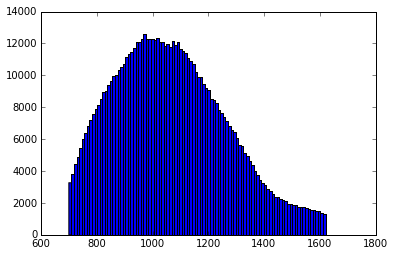

In [39]:
plt.hist(sig_cdc.get_events()[sig_cdc.time_name], bins=100)
show()

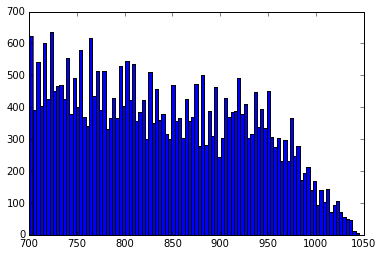

In [40]:
plt.hist(sig_cth.get_events()["CTHHit.fMCPos.fE"], bins=100)
show()

## Prepare the data

In [41]:
from tracking import HoughSpace
from scipy import sparse
from sklearn.metrics import roc_auc_score, roc_curve

In [42]:
back_sample_root = "/vols/comet/users/elg112/ICEDUST"\
                   "/local_storage/Blessed_Outputs/"
back_sample = back_sample_root + "4_2536_cdc_back.root"

In [43]:
import hits
reload(hits)
from hits import CyDetHits

In [44]:
print empty_branches

['CDCHit.fLayers', 'CDCHit.fCellID', 'CDCHit.fLocal_Score', 'CDCHit.fNeigh_Score', 'CDCHit.fHough_Score', 'CDCHit.fTrack_Score', 'CDCHit.fRelative_Time', 'CDCHit.fTake_Hit', 'CDCHit.fTrigTime', 'CDCHit.fIsSig']


In [45]:
print memory_usage()

[1341.51171875]


In [46]:
back_cdc = CyDetHits(back_sample, 
                     signal_coding=[1], 
                     row_name=row_name,
                     hit_type_name=sig_flag,
                     branches=these_branches,
                     empty_branches=empty_branches)

In [47]:
print memory_usage()

[1946.8203125]


In [48]:
print sum(back_cdc.get_events()["CDCHit.fDriftTime"] < 0)
print sum(back_cdc.get_events()["CDCHit.fDriftTime"] >= 0)
print back_cdc.get_events()["CDCHit.fDriftTime"][back_cdc.get_events()["CDCHit.fDriftTime"] < 0]
print np.amin(back_cdc.get_events()["CDCHit.fDriftTime"][back_cdc.get_events()["CDCHit.fDriftTime"] < 0])

63757
3970689
[-0.17655106 -0.16869333 -0.15328172 ..., -0.24650575 -0.24819626
 -0.01829378]
-0.378765165806


In [49]:
timing_cut=True

In [50]:
if timing_cut:
    # Apply the timing filter
    print "Back Events : {}".format(back_cdc.n_events)
    print "CyDet Hits: {}".format(back_cdc.n_hits)
    back_cdc.trim_hits(variable=back_cdc.time_name, greater_than=lower_bound_time, less_than=upper_bound_time_cdc)
    print "CyDet Hits: {}".format(back_cdc.n_hits)
    print "Back Events : {}".format(back_cdc.n_events)

Back Events : 2536
CyDet Hits: 4034446
CyDet Hits: 1430015
Back Events : 2536


### Add in the Signal events

In [51]:
n_events = min(back_cdc.n_events, sig_cdc.n_events)

In [52]:
print len(sig_cdc.get_signal_hits())
print len(sig_cdc.get_background_hits())
print len(back_cdc.get_signal_hits())
print len(back_cdc.get_background_hits())

713955
5598
0
1430015


In [53]:
back_cdc.trim_events(range(n_events))
sig_cdc.trim_events(range(n_events))
sig_cth.trim_events(range(n_events))

In [54]:
print len(sig_cdc.get_signal_hits())
print len(sig_cdc.get_background_hits())
print len(back_cdc.get_signal_hits())
print len(back_cdc.get_background_hits())

234962
1703
0
1430015


In [55]:
print memory_usage()
hits_cdc = back_cdc
hits_cdc.add_hits(sig_cdc.data)
del sig_cdc
print memory_usage()

[1528.38671875]
[1404.91796875]


### Set the Layer Value and Cell ID value

In [56]:
hits_cdc.data[hits_cdc.row_name] = geom.point_layers[hits_cdc.get_events()[hits_cdc.flat_name]]
hits_cdc.data[cell_id_name] = geom.point_indexes[hits_cdc.get_events()[hits_cdc.flat_name]]

In [57]:
#for branch in hits_cdc.data.dtype.names:
#    plt.title(branch)
#    plt.hist(hits_cdc.data[branch], bins=20)
#    plt.show()

### Set the trigger time and Relative Timing

In [58]:
event = np.random.randint(n_events)
print np.unique(sig_cth.get_events(event)[sig_cth.key_name])
print np.unique(hits_cdc.get_events(event)[hits_cdc.key_name])

[2376]
[2376 5990]


In [59]:
# Set the trigger times
trig_time_evt = []
for evt in range(n_events):
    sig_hits = sig_cth.get_signal_hits(evt)
    if len(sig_hits) != 0:
        this_trig_time = np.amin(sig_hits["CTHHit.fMCPos.fE"])
        trig_time_evt.append(this_trig_time)
        hits_cdc.data[hits_cdc.trig_name][hits_cdc.event_to_hits[evt]] = this_trig_time

#np.random.shuffle(trig_time_evt)
#for evt in range(n_events):
#    hits_cdc.data[hits_cdc.trig_name][hits_cdc.event_to_hits[evt]] = trig_time_evt[evt]

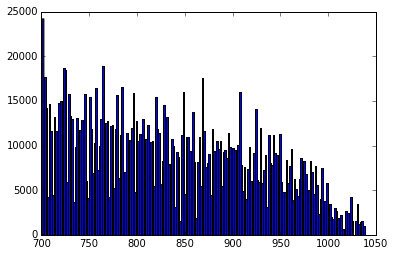

In [60]:
plt.hist(hits_cdc.data[hits_cdc.trig_name], bins=200)
plt.show()

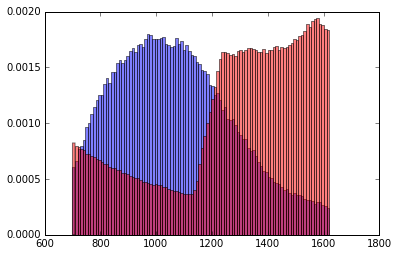

In [61]:
plt.hist(hits_cdc.get_signal_hits()[hits_cdc.time_name], 
         bins=100,  color='blue', alpha=0.5, normed=True, label="Signal")
plt.hist(hits_cdc.get_background_hits()[hits_cdc.time_name], 
         bins=100,  color='red', alpha=0.5, normed=True, label="Background")
show()

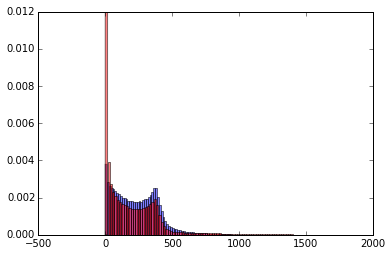

In [62]:
plt.hist(hits_cdc.get_signal_hits()[drift_name], 
         bins=100,  color='blue', alpha=0.5, normed=True, label="Signal")
plt.hist(hits_cdc.get_background_hits()[drift_name], 
         bins=100,  color='red', alpha=0.5, normed=True, label="Background")
show()

In [63]:
# Set the relative timing
hits_cdc.data[rel_time_name] = hits_cdc.data[hits_cdc.time_name] - hits_cdc.data[hits_cdc.trig_name]

# Begin the Analysis

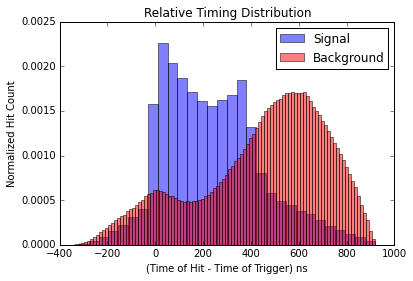

In [64]:
plt.title("Relative Timing Distribution")
plt.xlabel("(Time of Hit - Time of Trigger) ns")
plt.ylabel("Normalized Hit Count")
figsize(8,6)
plt.hist(hits_cdc.get_signal_hits()[rel_time_name], 
         bins=30,  color='blue', alpha=0.5, normed=True, label="Signal")
plt.hist(hits_cdc.get_background_hits()[rel_time_name], 
         bins=100,  color='red', alpha=0.5, normed=True, label="Background")
plt.legend()
show()

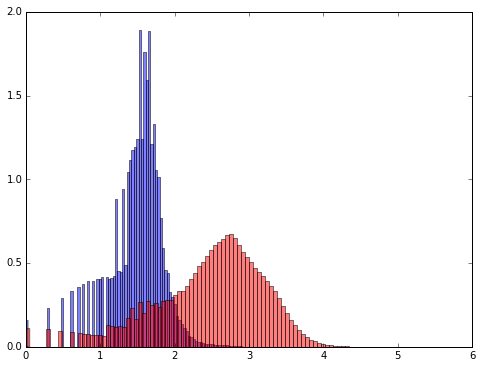

In [65]:
plt.hist(np.log10(hits_cdc.get_signal_hits()[hits_cdc.edep_name]), 
         bins=100,  color='blue', alpha=0.5, normed=True, label="Signal")
plt.hist(np.log10(hits_cdc.get_background_hits()[hits_cdc.edep_name]), 
         bins=100,  color='red', alpha=0.5, normed=True, label="Background")
show()

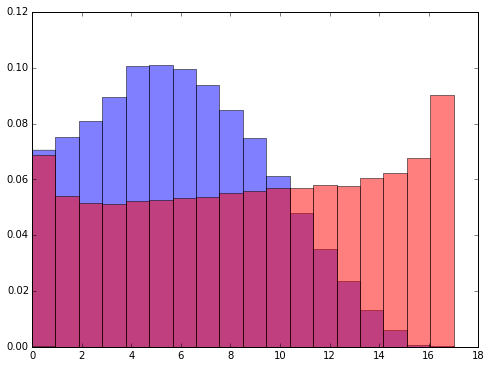

In [66]:
plt.hist(geom.point_layers[hits_cdc.get_signal_hits()[hits_cdc.flat_name]], 
         bins=18,  color='blue', alpha=0.5, normed=True, label="Signal")
plt.hist(geom.point_layers[hits_cdc.get_background_hits()[hits_cdc.flat_name]], 
         bins=18,  color='red', alpha=0.5, normed=True, label="Background")
show()

In [67]:
sig_occupancy = []
back_occupancy = []
occupancy = []

for event in range(hits_cdc.n_events):
    sig_occupancy += [len(np.unique(hits_cdc.get_signal_hits(event)[hits_cdc.flat_name]))]
    back_occupancy += [len(np.unique(hits_cdc.get_background_hits(event)[hits_cdc.flat_name]))]
    occupancy += [len(np.unique(hits_cdc.get_events(event)[hits_cdc.flat_name]))]    

In [68]:
avg_n_hits = np.average(hits_cdc.event_to_n_hits)
avg_n_hits = np.average(hits_cdc.event_to_n_hits)
avg_occ = np.average(occupancy)
print np.average(sig_occupancy), np.average(back_occupancy)

print avg_occ, avg_occ/4482
print avg_n_hits, (avg_n_hits - avg_occ)/float(avg_occ)

72.1762618297 500.808359621
564.693217666 0.125991347092
657.208201893 0.163832292177


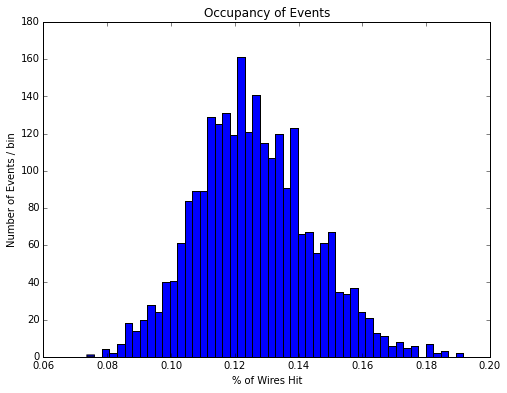

In [69]:
plt.title("Occupancy of Events")
plt.xlabel("% of Wires Hit")
plt.ylabel("Number of Events / bin")
plt.hist(np.array(occupancy)/4482., bins=50)
plt.show()

## Local Classification : Deal with Coincidence

### Make training/testing splits

In [70]:
def reset_masks(evt_samp, hit_sample):
    total_events = hit_sample.n_events
    total_hits = hit_sample.n_hits

    evt_samp_masks = [ np.zeros(total_events, dtype=bool) for samp in evt_samp ]
    hit_masks      = [ np.zeros(total_hits, dtype=bool) for samp in evt_samp ]
    for i in range(len(evt_samp)):
        evt_samp_masks[i][evt_samp[i]] = True
        hit_masks[i][hit_sample.get_events(evt_samp[i])[hit_sample.hits_index_name]] = True
    return evt_samp_masks, hit_masks

In [71]:
# Split up the data first
from sklearn.cross_validation import train_test_split

# Seed for sample mixing
seed = 10

# Get samples
rest = range(hits_cdc.n_events)
rest, sample_4     = train_test_split(rest, train_size=0.675, test_size=0.225, random_state=seed)
rest, sample_3     = train_test_split(rest, train_size=0.66, test_size=0.33, random_state=seed)
sample_1, sample_2 = train_test_split(rest, train_size=0.5, test_size=0.5, random_state=seed)

# Get event masks
evt_samp       = [ sample_1, sample_2, sample_3, sample_4 ]
evt_samp_masks, hit_masks = reset_masks(evt_samp, hits_cdc)

### Classify Using Local Features

In [72]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier, TMVAClassifier
from sklearn.ensemble import GradientBoostingClassifier
from rep.report.metrics import RocAuc
from pandas import DataFrame

In [73]:
# Define Data
train_features = [hits_cdc.edep_name, rel_time_name, hits_cdc.row_name]

In [74]:
factory = ClassifiersFactory()

# Define GBDT over neighbour-level features
local_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                    features=train_features)
# Add the GBDT
factory.add_classifier('Local Features', local_gbdt)

In [75]:
# Train the classifier
factory.fit(DataFrame(hits_cdc.data[train_features][hit_masks[0]]), 
            hits_cdc.data[hits_cdc.hit_type_name][hit_masks[0]])
pass

model Local Features was trained in 44.65 seconds
Totally spent 44.65 seconds on training


In [76]:
hits_cdc.print_branches()

Branches available are:
CDCHit.fDriftTime
CDCHit.fTrack.fTrackID
CDCHit.fEventNumber
CDCHit.fhits_index
CDCHit.fevent_index
CDCHit.fCellID
CDCHit.fHough_Score
CDCHit.fIsSig
CDCHit.fLayers
CDCHit.fLocal_Score
CDCHit.fNeigh_Score
CDCHit.fRelative_Time
CDCHit.fTake_Hit
CDCHit.fTrack_Score
CDCHit.fTrigTime
CDCHit.fvol_id
CDCHit.fCharge
CDCHit.fDetectedTime


In [77]:
# Print these predictions
hits_cdc.data[lcl_scr_name] = local_gbdt.predict_proba(DataFrame(hits_cdc.data[train_features]))[:,1]
# Invalidate the training sample
hits_cdc.data[lcl_scr_name][hit_masks[0]] = -1

In [78]:
# Sort events by channel, by score
hits_cdc.sort_hits([hits_cdc.flat_name, lcl_scr_name])
# Recored which hit have the best score by event by channel
all_hits_to_take = []
# Stats about hit removal
removal_stats = {"is_sig, more_sig"    : 0,
                 "is_sig, no_more_sig" : 0,
                 "not_sig, more_sig"    : 0,
                 "not_sig, no_sig"      : 0}

# Loop over all events
for evt in range(hits_cdc.n_events):
    event_hits = hits_cdc.get_events(evt)
    for channel in np.unique(event_hits[hits_cdc.flat_name]):
        chan_hits = hits_cdc.filter_hits(event_hits, hits_cdc.flat_name, channel)
        this_chan_hit = chan_hits[hits_cdc.hits_index_name][-1]
        all_hits_to_take.append(this_chan_hit)
        # Check for coincidence
        if len(chan_hits) > 1:
            # Check the channel content
            is_sig = hits_cdc.data[this_chan_hit][hits_cdc.hit_type_name] == 1
            # Check if there was more signal
            has_more_sig = (sum(chan_hits[hits_cdc.hit_type_name] == 1) - is_sig) > 0
            # Check which hit we chose
            if is_sig and has_more_sig:
                removal_stats["is_sig, more_sig"] += 1
            elif is_sig and not has_more_sig:
                removal_stats["is_sig, no_more_sig"] += 1
            elif not is_sig and has_more_sig:
                removal_stats["not_sig, more_sig"] += 1
            else:
                removal_stats["not_sig, no_sig"] += 1

In [79]:
pprint(removal_stats)
print sum(hits_cdc.get_events()["CDCHit.fIsSig"])
print sum(removal_stats.values())

{'is_sig, more_sig': 34788,
 'is_sig, no_more_sig': 14731,
 'not_sig, more_sig': 2622,
 'not_sig, no_sig': 133198}
234962.0
185339


In [80]:
# Make a mask
chan_hit_mask = np.zeros(hits_cdc.n_hits, dtype=bool)
chan_hit_mask[all_hits_to_take] = 1
# Set the hits to take as channel hit
hits_cdc.data[take_hit_name][chan_hit_mask] = 1
# Trim the hits we are not going to look at
hits_cdc.trim_hits(take_hit_name, values=1)
hits_cdc.sort_hits(hits_cdc.flat_name)
evt_samp_masks, hit_masks = reset_masks(evt_samp, hits_cdc)

0.968872239814


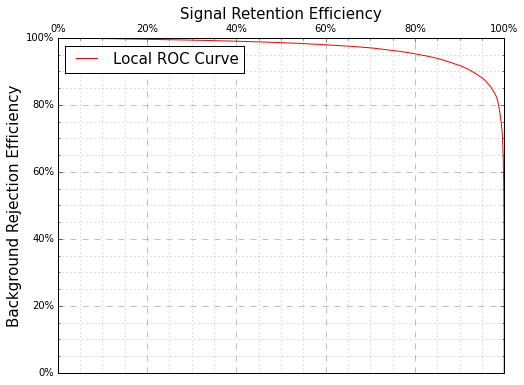

In [81]:
plot_roc_curve(hits_cdc.data[hits_cdc.hit_type_name][np.logical_not(hit_masks[0])], 
               hits_cdc.data[lcl_scr_name][np.logical_not(hit_masks[0])], 
               zoom=False, label="Local ROC Curve")
print roc_auc_score(hits_cdc.data[hits_cdc.hit_type_name][np.logical_not(hit_masks[0])], 
               hits_cdc.data[lcl_scr_name][np.logical_not(hit_masks[0])])
plt.show()

## Use Neighbour Level Features

In [82]:
# Define Data
neigh_train_features = [hits_cdc.edep_name, 
                        hits_cdc.edep_name + "_left",
                        hits_cdc.edep_name + "_right",
                        rel_time_name, 
                        rel_time_name + "_left",
                        rel_time_name + "_right",
                        hits_cdc.row_name]

In [83]:
# Define GBDT over neighbour-level features
neigh_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                    features=neigh_train_features)
# Add the GBDT
factory.add_classifier('Neighbour and Local Features', neigh_gbdt)

In [84]:
# Train the classifier
factory.fit(DataFrame(
                np.vstack(
                    get_measurment_and_neighbours(hits_cdc, hits_cdc.edep_name, evt_samp[1]) +\
                    get_measurment_and_neighbours(hits_cdc, hits_cdc.time_name, evt_samp[1]) +\
                    [hits_cdc.data[hits_cdc.row_name][hit_masks[1]]]).T,
                columns=neigh_train_features), 
            hits_cdc.data[hits_cdc.hit_type_name][hit_masks[1]])
pass

model Local Features was trained in 36.06 seconds
model Neighbour and Local Features was trained in 67.15 seconds
Totally spent 103.21 seconds on training


In [85]:
# Print these predictions
hits_cdc.data[ngh_scr_name] = neigh_gbdt.predict_proba(
    DataFrame(
        np.vstack(
            get_measurment_and_neighbours(hits_cdc, hits_cdc.edep_name) +\
            get_measurment_and_neighbours(hits_cdc, hits_cdc.time_name) +\
            [hits_cdc.data[hits_cdc.row_name]]).T,
        columns=neigh_train_features))[:,1]
# Invalidate the training sample
hits_cdc.data[ngh_scr_name][np.logical_or(hit_masks[0], hit_masks[1])] = -1

0.98494670597


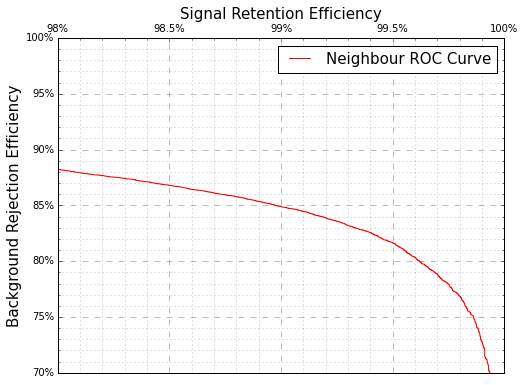

In [86]:
plot_roc_curve(hits_cdc.data[hits_cdc.hit_type_name][np.logical_or(hit_masks[2],hit_masks[3])], 
               hits_cdc.data[ngh_scr_name][np.logical_or(hit_masks[2],hit_masks[3])], 
               zoom=True, label="Neighbour ROC Curve")
print roc_auc_score(hits_cdc.data[hits_cdc.hit_type_name][np.logical_or(hit_masks[2],hit_masks[3])], 
               hits_cdc.data[ngh_scr_name][np.logical_or(hit_masks[2],hit_masks[3])])
plt.show()

In [87]:
# Define which wires we want to correct as hits which were missclassified 
problem_weights_2 = abs(hits_cdc.data[hits_cdc.hit_type_name][hit_masks[2]]
                        - hits_cdc.data[ngh_scr_name][hit_masks[2]]) ** 2

In [88]:
print roc_auc_score(hits_cdc.data[hits_cdc.hit_type_name][hit_masks[2]], 
                    hits_cdc.data[ngh_scr_name][hit_masks[2]])
print roc_auc_score(hits_cdc.data[hits_cdc.hit_type_name][hit_masks[2]], 
                    hits_cdc.data[ngh_scr_name][hit_masks[2]],
                    sample_weight=problem_weights_2)

0.984249208796
0.165569499733


In [89]:
from tracking import HoughSpace

default = [[31.5, 34, 34.5, 2]]
submatrices = []

# TODO test with several radii
for rmin, rmean, rmax, rsgma in default: #[[30, 33, 35], [26, 29, 32]]:
    # Try with default values
    hough = HoughSpace(geom, sig_rho_min=rmin, sig_rho=rmean, sig_rho_max=rmax,\
                       sig_rho_sgma=rsgma, rho_bins=20, arc_bins=81)
    corresp = hough.correspondence
    submatrices.append(corresp)

# Stack all submatricies horizontally
new_correspondence = sparse.hstack(submatrices)

In [90]:
import tracking
reload(tracking)

<module 'tracking' from '../modules/tracking.pyc'>

In [91]:
from tracking import HoughTransformer, HoughShifter
# Fit and transform the second data sample
hough_transformer = HoughTransformer(new_correspondence, \
                                     hough.norm_track_neighs,\
                                     hits_cdc.get_measurement(ngh_scr_name,
                                                              events=evt_samp[2],
                                                              only_hits=False,
                                                              flatten=False),
                                     alpha_max=2., alpha_rw=2.)

In [92]:
# Get the hough results
#hough_score, hough_images = \
hits_cdc.data[hgh_scr_name], hough_images = \
        hough_transformer.transform(hits_cdc.get_measurement(ngh_scr_name, 
                                                             only_hits=False, 
                                                             flatten=False),
                                   only_hits=True, flatten=True)

In [93]:
# Add this to the feature list
track_train_features = neigh_train_features + [hgh_scr_name]

# Define the new classifier
hough_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                               features=track_train_features) 

# Define GBDT over only energy deposit to compare
dep_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=200), 
                               features=[hits_cdc.edep_name])

# Ensure neigh-level GBDT has enough trees to compare properly
neigh_gbdt.set_params(n_estimators=200)
local_gbdt.set_params(n_estimators=200)

# Add the classifiers
factory.add_classifier('Track, Local and Neighbour Features', hough_gbdt)
factory.add_classifier('Energy Deposition', dep_gbdt)

In [94]:
# Train the classifier
factory.fit(DataFrame(
                np.vstack(
                    get_measurment_and_neighbours(hits_cdc, hits_cdc.edep_name, evt_samp[2]) +\
                    get_measurment_and_neighbours(hits_cdc, hits_cdc.time_name, evt_samp[2]) +\
                    [hits_cdc.data[hits_cdc.row_name][hit_masks[2]]] +\
                    [hits_cdc.data[hgh_scr_name][hit_masks[2]]]).T,
                columns=track_train_features), 
            hits_cdc.data[hits_cdc.hit_type_name][hit_masks[2]])
pass

model Local Features was trained in 71.91 seconds
model Neighbour and Local Features was trained in 132.44 seconds
model Track, Local and Neighbour Features was trained in 71.97 seconds
model Energy Deposition was trained in 38.81 seconds
Totally spent 315.14 seconds on training


In [95]:
# Test it on the last set of data
hits_cdc.data[trk_scr_name] = hough_gbdt.predict_proba(
        DataFrame(
            np.vstack(
                    get_measurment_and_neighbours(hits_cdc, hits_cdc.edep_name) +\
                    get_measurment_and_neighbours(hits_cdc, hits_cdc.time_name) +\
                    [hits_cdc.data[hits_cdc.row_name]] +\
                    [hits_cdc.data[hgh_scr_name]]).T,
            columns=track_train_features)
        )[:,1]
# Invalidate the training sample
hits_cdc.data[trk_scr_name][np.logical_not(hit_masks[3])] = -1

In [96]:
final_diagnostics = factory.test_on(
    DataFrame(
        np.vstack(
            get_measurment_and_neighbours(hits_cdc, hits_cdc.edep_name, evt_samp[3]) +\
            get_measurment_and_neighbours(hits_cdc, hits_cdc.time_name, evt_samp[3]) +\
            [hits_cdc.data[hits_cdc.row_name][hit_masks[3]]] +\
            [hits_cdc.data[hgh_scr_name][hit_masks[3]]]).T,
        columns=track_train_features), 
    hits_cdc.data[hits_cdc.hit_type_name][hit_masks[3]])

# Visualize The Results

/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


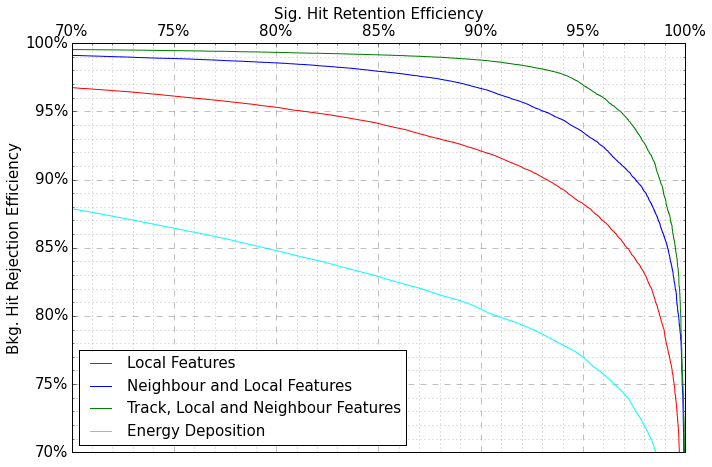

In [97]:
plot_set_font()
figsize(11, 7.3333)
plot_rocs(hits_cdc.get_measurement(hits_cdc.hit_type_name,
                                   events=evt_samp[3],
                                   only_hits=True,
                                   flatten=True), 
         final_diagnostics.prediction, 
         zoom=True,
         datum_label="Hit")
plt.show()

In [98]:
labels = np.take([0,2,1], hits_cdc.get_measurement("CDCHit.fIsSig", 
                                   default=-1, 
                                   only_hits=True,
                                   flatten=True).astype(int) + 1)

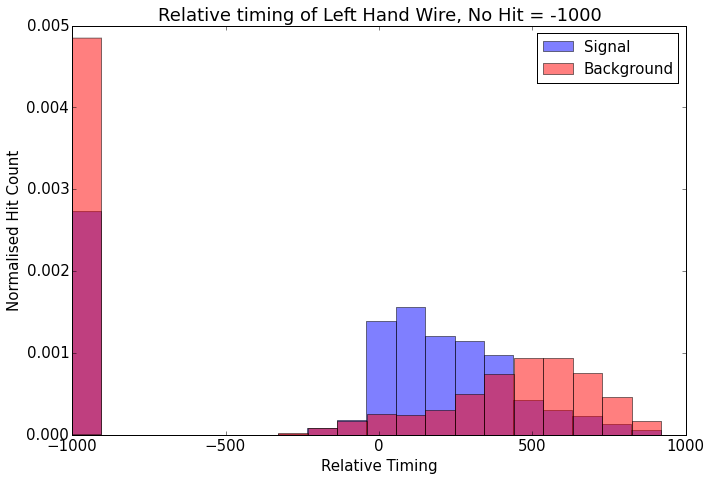

In [99]:
plot_feature( hits_cdc.get_measurement(rel_time_name, 
                                       flatten=True, 
                                       shift=-1, 
                                       default=-1000), 
              labels, 
              xlabel="Relative Timing", ylabel="Normalised Hit Count", 
              title="Relative timing of Left Hand Wire, No Hit = -1000",
              xlog=False, nbins=20)
show()

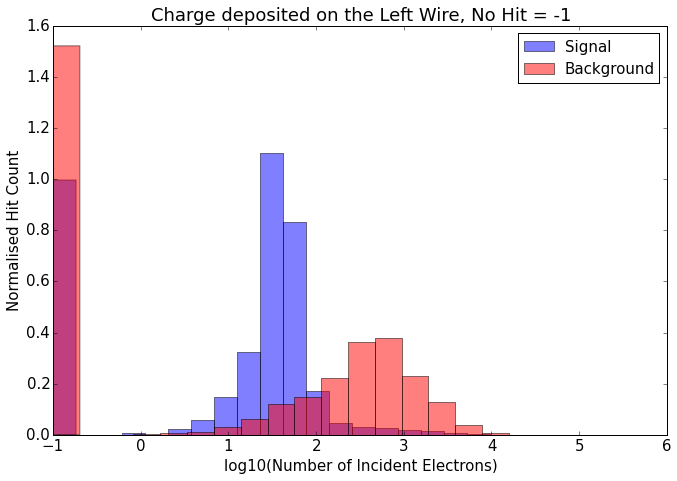

In [100]:
plot_feature( np.log10(hits_cdc.get_measurement(hits_cdc.edep_name, flatten=True, shift=-1) + 0.1), 
              labels, 
              xlabel="log10(Number of Incident Electrons)", 
              ylabel="Normalised Hit Count", xlog=False,
              title="Charge deposited on the Left Wire, No Hit = -1", 
              nbins=20)
show()

(<matplotlib.axes._subplots.AxesSubplot at 0xc22cdd0>,
 <matplotlib.figure.Figure at 0xbafd090>)

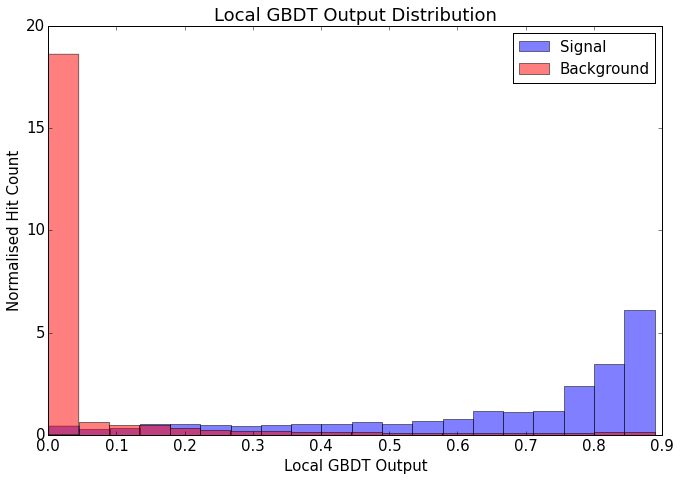

In [101]:
plot_feature( hits_cdc.get_events()[lcl_scr_name][np.logical_not(hit_masks[0])], 
              labels[np.logical_not(hit_masks[0])], 
              xlabel="Local GBDT Output", ylabel="Normalised Hit Count", xlog=False,
              title="Local GBDT Output Distribution", nbins=20)

(<matplotlib.axes._subplots.AxesSubplot at 0x6048410>,
 <matplotlib.figure.Figure at 0xbd13810>)

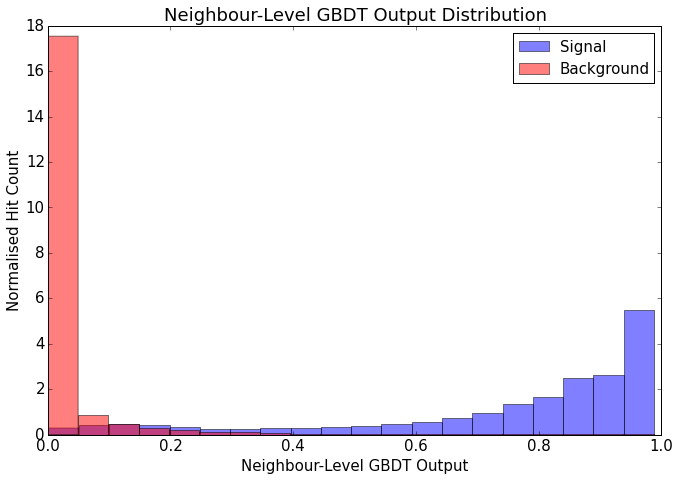

In [102]:
plot_feature( hits_cdc.get_events()[ngh_scr_name][np.logical_or(hit_masks[2], hit_masks[3])], 
              labels[np.logical_or(hit_masks[2], hit_masks[3])], 
              xlabel="Neighbour-Level GBDT Output", ylabel="Normalised Hit Count", xlog=False,
              title="Neighbour-Level GBDT Output Distribution", nbins=20)

(<matplotlib.axes._subplots.AxesSubplot at 0xe2ca990>,
 <matplotlib.figure.Figure at 0xca31b50>)

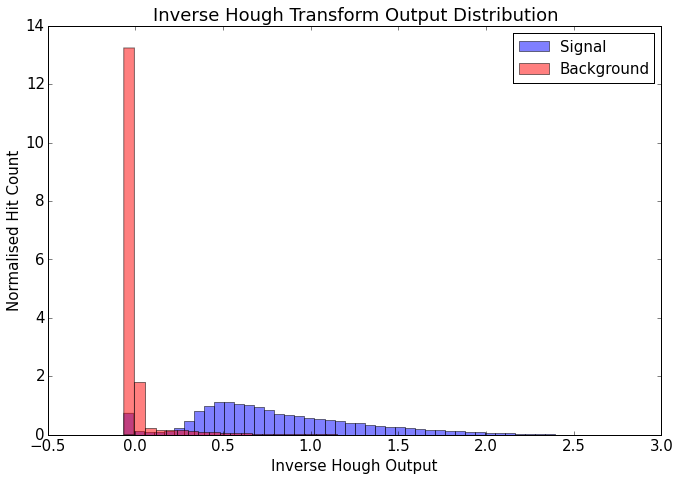

In [103]:
plot_feature( hits_cdc.get_events()[hgh_scr_name][np.logical_or(hit_masks[2], hit_masks[3])], 
              labels[np.logical_or(hit_masks[2], hit_masks[3])], 
              xlabel="Inverse Hough Output", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Inverse Hough Transform Output Distribution", 
              nbins=50)

(<matplotlib.axes._subplots.AxesSubplot at 0xe9f6650>,
 <matplotlib.figure.Figure at 0x1eb913d0>)

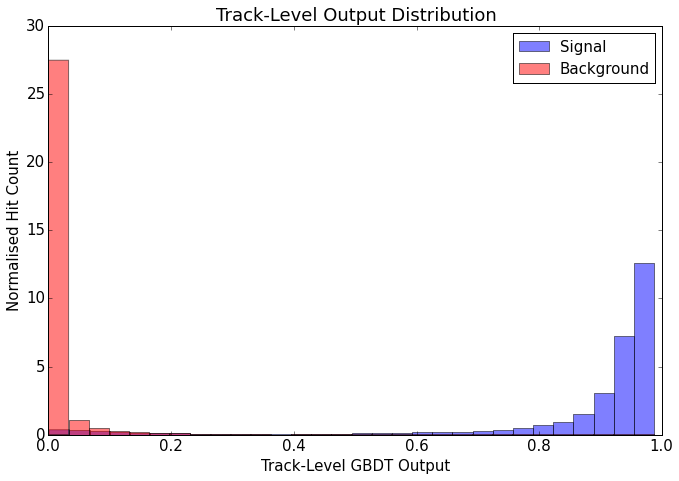

In [104]:
plot_feature( hits_cdc.get_events()[trk_scr_name][hit_masks[3]], 
              labels[hit_masks[3]], 
              xlabel="Track-Level GBDT Output", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Track-Level Output Distribution", 
              nbins=30)

In [105]:
# TODO clean this up
from collections import OrderedDict

#figsize(6.4,6.4) 
feat_label_dict = OrderedDict([
            (rel_time_name,               "Timing"),  
            (rel_time_name     +"_left",  "Left Timing"),  
            (rel_time_name     +"_right", "Right Timing"),  
            (hits_cdc.edep_name,          "Charge"),  
            (hits_cdc.edep_name+"_left",  "Left Charge"),  
            (hits_cdc.edep_name+"_right", "Right Charge"),  
            (hits_cdc.row_name,           "R Distance"),  
            (hgh_scr_name,               r"Hough, $W_j'$")
    ])

def plot_feature_importance(rep_classifier, feat_label_dict, font_size=None):
    feat_import = rep_classifier.get_feature_importances()
    feat_import = feat_import.sort("effect", ascending=True)
    ax = plt.subplot(111)
    ax.barh( np.arange(len(feat_import.values)), feat_import.values,zorder=10)
    ax.set_yticks(np.arange(len(feat_import.values))+0.5)
    ax.minorticks_on()
    ax.set_xlabel("Normalized Relative Usage")
    ax.set_title("Feature Importance")
    ax.autoscale()
    ax.grid(b=True, which='major', axis='x' ,color='grey', linestyle='--', lw=2)
    ax.grid(b=True, which='minor', axis='x' , color='grey', linestyle=':', lw=2)
    ordered_labels = OrderedDict((key, feat_label_dict[key]) for key in feat_import.index.values)
    ax.set_yticklabels(ordered_labels.values(), fontsize = font_size)
    #ax.set_xticks([tick for tick in ax.get_xticks()[::2]])
    ax.set_xticklabels(["{:.0f}%".format(tick*100) for tick in ax.get_xticks()], fontsize = font_size)
    return ax

def plot_feature_correlations(rep_factory, feat_label_dict, title="", font_size=None):
    corr = rep_factory.features_correlation_matrix(features=feat_label_dict.keys(),
                                tick_labels=feat_label_dict.values())
    corr.fontsize = font_size
    corr.cmap = "RdBu"
    return corr.plot(title=title)

/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


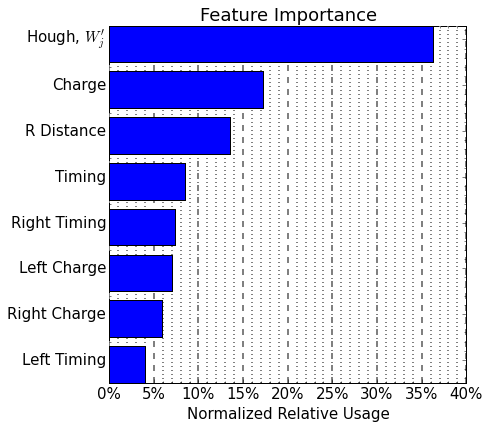

/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


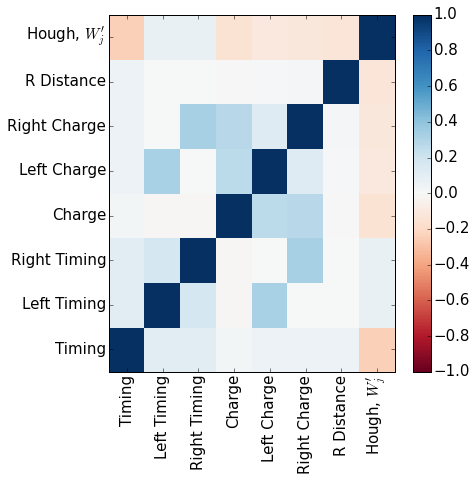

In [106]:
figsize(6.4,6.4) 
plot_feature_importance(hough_gbdt, feat_label_dict)
show()
plot_feature_correlations(final_diagnostics, feat_label_dict)
show()

/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


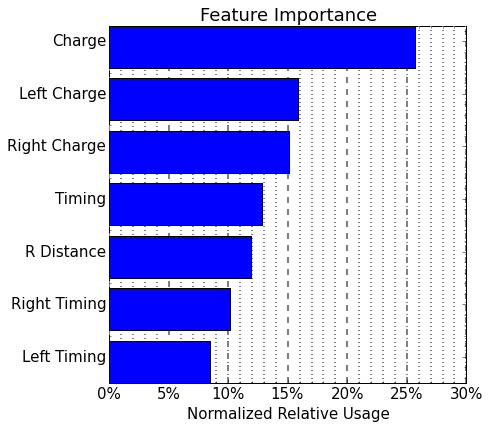

In [107]:
plot_feature_importance(neigh_gbdt, feat_label_dict)
show()

## Visualiaze the Data

In [113]:
high_hit = np.array(evt_samp[3])[hits_cdc.event_to_n_hits[evt_samp[3]] >= 600]
#high_hit = np.where(hits_cdc.event_to_n_hits >= 800)[0]
n_sig = np.array([len(hits_cdc.get_signal_hits(evt)) for evt in high_hit])
good_event = high_hit[n_sig < 80]
print len(good_event)
print good_event

98
[1198 1853  835 1790  539  928 1003 1471 2352  464  317  719  832 2410 1494
  210 2452  731  794 1079 1822   25  847 2313  838 1042 1950  724 1839  174
 1024 1705  684  152 1166  264  984 2061  891 1348 2499 2099  582 2209 2194
 2528 1803 2204  202 2029  942 1158 2434 1733 1337  973 1924 1216  799  342
   18  173 2245 2055  423 1696 2237  850 2287 1788 1646 1843  815 1026  203
 1886  163 1059  311  248  695  886 1369 1568 2341  258 1448 1333 1888  194
  708 2159 2014 1861 2407  243  463 1088]


In [114]:
print hough_images.shape

(2536, 5654)


In [115]:
# Event information\
event = 7
event = good_event[event]
#event = evt_samp[3][event]
add_trans = True
save = True
savedir = "/vols/comet/users/elg112/ICEDUST/track-finding-yandex/review_meeting_plots/"

to_plot = np.take([0,2,1], hits_cdc.get_measurement("CDCHit.fIsSig", 
                                   events=event, 
                                   default=-1, 
                                   only_hits=False,
                                   flatten=True).astype(int) + 1)
ngh_pred_size = plot_norm_size(hits_cdc.get_measurement(ngh_scr_name, 
                                                        events=event, 
                                                        default=0, 
                                                        only_hits=False,
                                                        flatten=True))
trk_pred_size = plot_norm_size(hits_cdc.get_measurement(trk_scr_name, 
                                                        events=event, 
                                                        default=0, 
                                                        only_hits=False,
                                                        flatten=True))
hough_output = hits_cdc.get_measurement(hgh_scr_name, 
                                        events=event, 
                                        default=0, 
                                        only_hits=False,
                                        flatten=True)

#hough_event = evt_samp[3][event]
hough_event = event

plot_hough_image_3 = hough_images[hough_event,:hough.track.n_points] +\
                     hough_images[hough_event,hough.track.n_points:] 
plot_hough_no_rw = hough_transformer.normed_corresp.T.dot(ngh_pred_size.T).T
plot_hough_no_rw = plot_hough_no_rw[:hough.track.n_points] + plot_hough_no_rw[hough.track.n_points:]

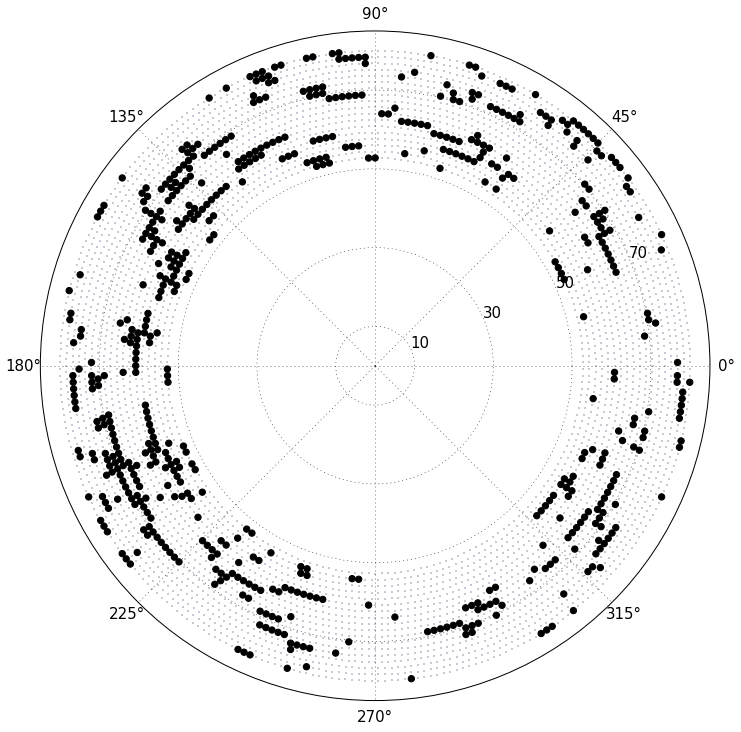

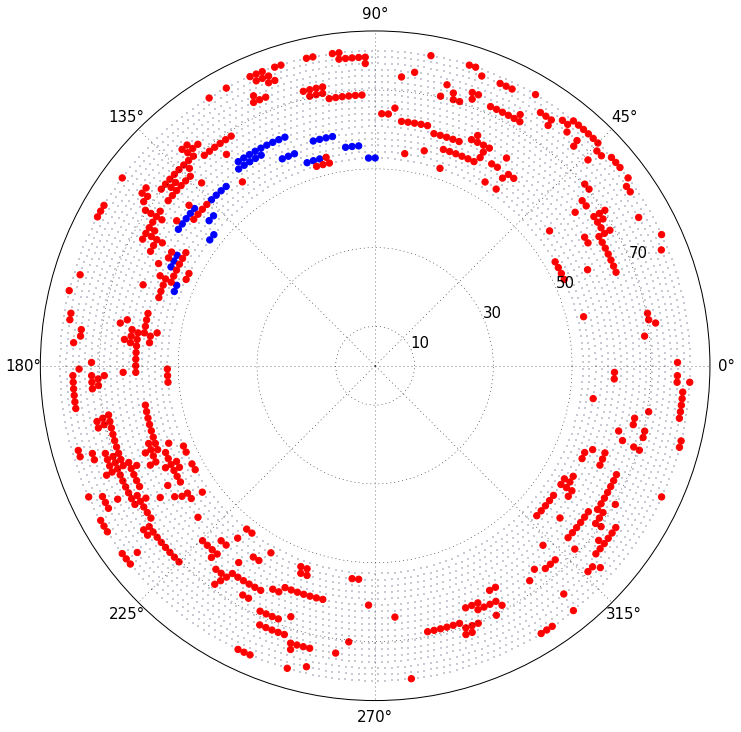

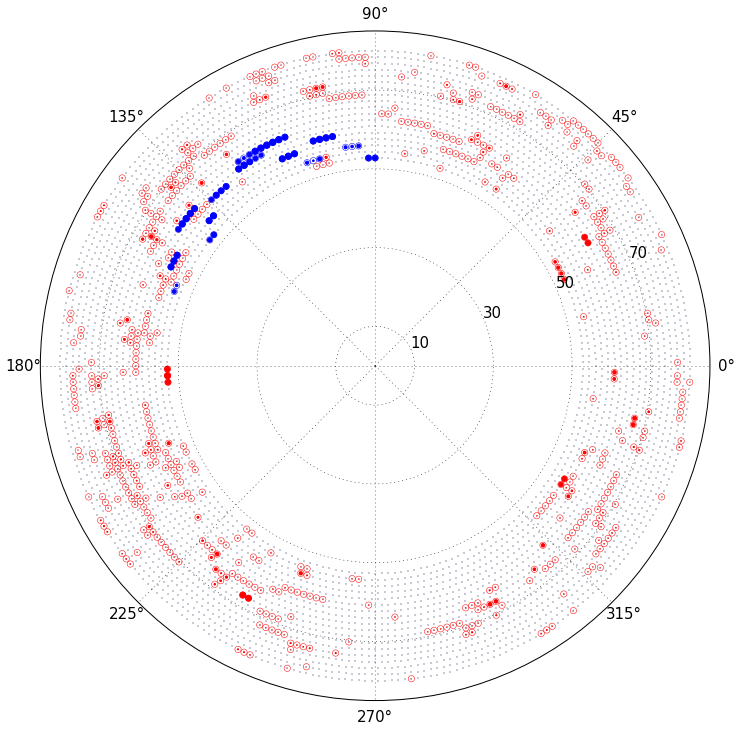

/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Length of draw tracks are 2531


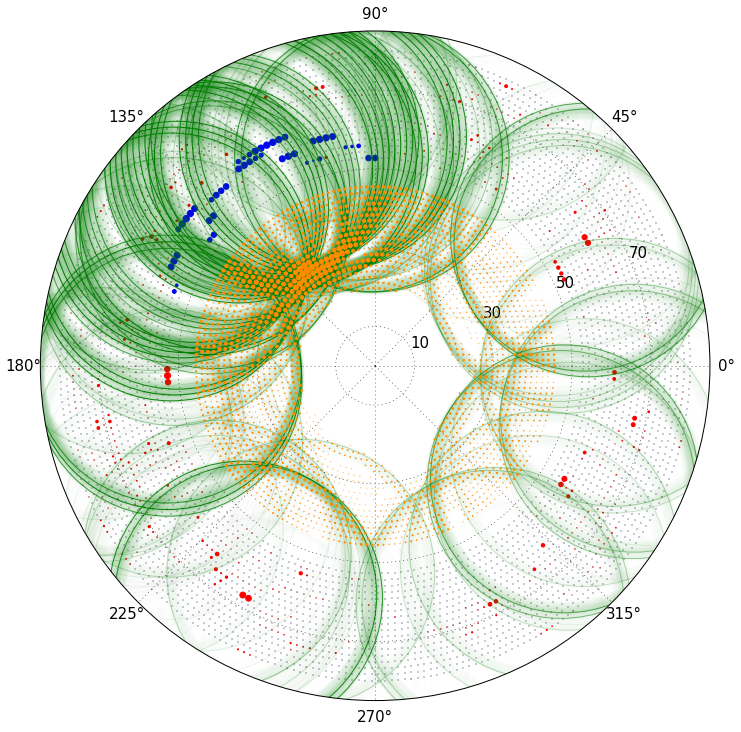

Length of draw tracks are 63


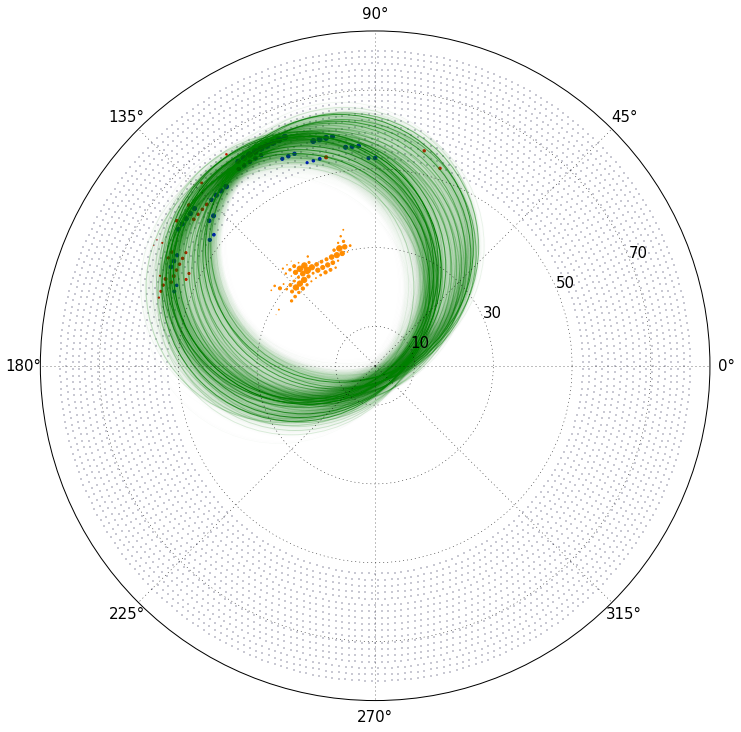

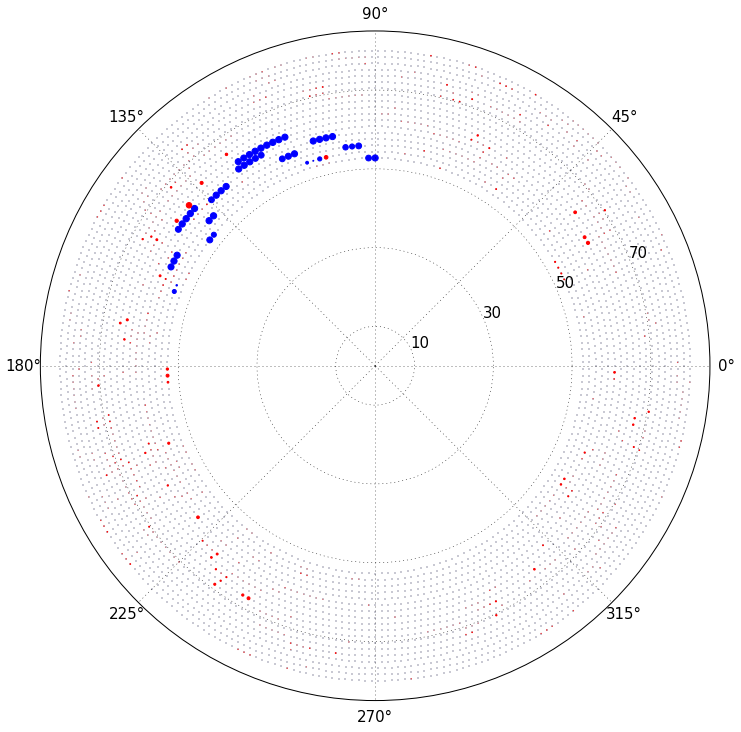

In [116]:
# Basic output
plot_output(to_plot, geom, sig_color='black', bkg_color='black', )
if save:
    plt.savefig(savedir+"plot_event_bw.png", bbox_inches='tight')
show()

plot_output(to_plot, geom)
if save:
    plt.savefig(savedir+"plot_event.png", bbox_inches='tight')
show()

# First GBDT output
plot_output(to_plot, geom, 
            size=ngh_pred_size)
plot_add_outlines(to_plot, geom)
if save:
    plt.savefig(savedir+"plot_neigh_level.png", bbox_inches='tight')
show()

# Hough output
plot_output(to_plot, geom, 
            size=ngh_pred_size, 
            add_transform=add_trans)
plot_add_tracks(geom, hough, 
                size=plot_norm_size(plot_hough_no_rw - np.amin(plot_hough_no_rw),40))
if save:
    plt.savefig(savedir+"plot_hough.png", bbox_inches='tight')
show()

# Inverse Hough output
plot_output(to_plot, geom, 
            size=plot_norm_size(hough_output))
plot_add_tracks(geom, hough, 
                size=plot_norm_size(plot_hough_image_3,40), 
                add_transform=add_trans,
                tolerance=0.00)
if save:
    plt.savefig(savedir+"plot_inv_hough.png", bbox_inches='tight')
show()    

# Final
plot_output(to_plot, geom, size=plot_norm_size(trk_pred_size))
if save:
    plt.savefig(savedir+"plot_final.png", bbox_inches='tight')
show()

## Export the Data

In [ ]:
from tabulate import tabulate

In [ ]:
export_name = "track_finding_sample_scored_2.root"

In [ ]:
hits_cdc.trim_hits(hits_cdc.hits_index_name, 
                   values=hits_cdc.data[hit_masks[3]][hits_cdc.hits_index_name])

In [ ]:
from rootpy.tree import Tree, TreeModel, FloatCol, IntCol
from rootpy.io import root_open
from rootpy.vector import LorentzVector
from rootpy import stl
from random import gauss, randint

# Map from python types to c++ types
type_dict = {dtype('float64'):"double", 
             dtype('int32')  :"long",
             dtype('int64')  :"long"}

# Define the model of the output root file
class CDCTree(TreeModel):
    # Create a std::vector branch for each measurement
    for measure in hits_cdc.data.dtype.names:
        this_dtype = type_dict[hits_cdc.data.dtype[measure]]
        measure = measure.replace(".", "_")
        exec(measure + " = stl.vector(this_dtype)")
    # Delete branches we do not want
    del measure, this_dtype

# Open the output file
with root_open(savedir+export_name, mode='recreate') as output_file:
    # Open a new tree
    output_tree = Tree("test", model=CDCTree)
    for event in range(hits_cdc.n_events):
        if event%100 == 0:
            print event
        event_hits = hits_cdc.get_events(event)
        for measure in event_hits.dtype.names:
            this_measure = event_hits[measure]
            for hit_val in this_measure:
                output_tree[measure.replace(".","_")].push_back(hit_val)
        output_tree.fill(reset=True)
    output_tree.write()

In [ ]:
fpr, tpr, thresh = roc_curve(hits_cdc.data["CDCHit.fIsSig"], 
          hits_cdc.data[trk_scr_name])

In [124]:
def print_tpr_fpr(my_fpr, my_tpr, my_thresh, 
                  threshold_min=80, threshold_max=100, 
                  bins=100., steps=1,
                  filename=None):
    table = list()
    table.append([ "Bkg Retained", "Sig Retained", 'Threshold'])
    for this_thresh in np.arange(threshold_min,threshold_max, steps)[::-1]/float(bins):
        table.append([1. - this_thresh, my_tpr[my_fpr < 1. - this_thresh][-1], thresh[fpr < 1. - this_thresh][-1]])
    print tabulate(table, headers="firstrow")

In [125]:
print_tpr_fpr(fpr, tpr, thresh, threshold_min=80, threshold_max=100, bins=100)
print_tpr_fpr(fpr, tpr, thresh, threshold_min=900, threshold_max=1000, bins=1000, steps=5)

  Bkg Retained    Sig Retained    Threshold
--------------  --------------  -----------
          0.01        0.977989  0.440657
          0.02        0.994991  0.100466
          0.03        0.99761   0.0424593
          0.04        0.998507  0.0202806
          0.05        0.998667  0.0101221
          0.06        0.998736  0.00532628
          0.07        0.998782  0.00293396
          0.08        0.999196  0.00200273
          0.09        0.999563  0.00152504
          0.1         0.999701  0.00126688
          0.11        0.999747  0.00111337
          0.12        0.999816  0.00100525
          0.13        0.999908  0.000927539
          0.14        0.999954  0.000858466
          0.15        0.999977  0.000804307
          0.16        0.999977  0.000765129
          0.17        0.999977  0.000730593
          0.18        0.999977  0.000697145
          0.19        0.999977  0.000668738
          0.2         0.999977  0.000644061
  Bkg Retained    Sig Retained    Threshold
-------

In [ ]:
# TODO 
# Plots for Louis

# Penalize for not being the closest point to the fit



# Belle-II literature
# multiple radii
# optimize hough to improve track purity, use RANSAC to shed background islands
# 

#TODO Offline Analysis
# THURS penalize on no hits for RANSAC
# THURS change sampling probability via GBDT score
# THURS change scoring weight by GBDT score
# FRI check results for mulitple radii, no optimization
# FRI check results for varying hit efficiencies, no optimization


# In[73]:

#TODO Online
# TUES Integrate trigger signal in


# In[75]:

# NOTES
## Shifting to align image in hough space must 
#  play well with the placticity already 
#  implimented in the algorithm.  Adjust reweighting
## Try reweighting background hits close to signal hits
#  as worse when we do the track level GBDT algo.  Rid
#  background islands at RANSAC level.